In [ ]:
# https://rasbt.github.io/mlxtend/user_guide/data/loadlocal_mnist/
!curl -O http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
!gunzip t*-ubyte.gz
!pip install mlxtend

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.data import loadlocal_mnist

In [110]:
''''
group member 1: Andrei Ilic
group member 2: Georgy Antonov

'''

# Provide paths to the local MNIST dataset
train_im_path  = '/Users/GA/Documents/Tübingen/DNNs/Homework/Code/mnist/train-images-idx3-ubyte'
train_lab_path = '/Users/GA/Documents/Tübingen/DNNs/Homework/Code/mnist/train-labels-idx1-ubyte'
test_im_path   = '/Users/GA/Documents/Tübingen/DNNs/Homework/Code/mnist/t10k-images-idx3-ubyte'
test_lab_path  = '/Users/GA/Documents/Tübingen/DNNs/Homework/Code/mnist/t10k-labels-idx1-ubyte'

# Load 
X_train, y_train = loadlocal_mnist(
                    images_path=train_im_path, 
                    labels_path=train_lab_path)

X_test, y_test = loadlocal_mnist(
                   images_path=test_im_path, 
                   labels_path=test_lab_path)

print('Dimensions: %s x %s' % (X_train.shape[0], X_train.shape[1]))

Dimensions: 60000 x 784


In [111]:
# split eval data from train data:
eval_data_size = 10000
train_data_size = 50000
test_data_size = 10000

X_eval = X_train[0:10000, :]
y_eval = y_train[0:10000]
X_train = X_train[10000:, :]
y_train = y_train[10000:]

# Datatype float allows you to subtract images (is otherwise uint8)
X_train = X_train.astype(float)
y_train = y_train.astype(float)
X_test = X_test.astype(float)
y_test = y_test.astype(float)
print("x shapes:")
print(X_train.shape, X_eval.shape, X_test.shape)
# normalize train data from range 0 to 255 to range 0 to 1
X_train = X_train / 255
X_eval = X_eval / 255
X_test = X_test / 255

x shapes:
(50000, 784) (10000, 784) (10000, 784)


In [112]:
# transform to y to one hot encoded vectors:
# each row is one y vector
def make_one_hot(v):
    """
    :param v: vector of the length of the dataset containing class labels from 0 to 9
    :return: a matrix of dim(length dataset,10), where the index of the corresponding label is set to one.
    """
    num_samples = len(v)
    num_labels  = len(np.unique(v))
    
    tmp = np.zeros((num_samples, num_labels))
    for i in range(len(v)):
        idx = int(v[i])
        tmp[i][idx] = 1
    v_one_hot = tmp
    return v_one_hot

y_train = make_one_hot(y_train)
y_eval = make_one_hot(y_eval)
y_test = make_one_hot(y_test)
print("y shapes:")
print(y_train.shape, y_eval.shape, y_test.shape)

y shapes:
(50000, 10) (10000, 10) (10000, 10)


In [140]:
# TODO for task d adapt the following parameters to achieve better results
batch_size = 250
epochs = 20
learning_rate = 0.01

# usually one would use a random weight initialization, but for reproducible results we use fixed weights
# Don't change these parameters
W = np.ones((784, 10)) * 0.01
b = np.ones((10)) * 0.01

# b = np.repeat(b, batch_size, axis=0).reshape(10, batch_size)

def get_next_batch(iteration, batch_size, data, label):
    X = data[iteration * batch_size:(iteration + 1) * batch_size, :]
    y = label[iteration * batch_size:(iteration + 1) * batch_size, :]
    return X, y

def get_loss(y_hat, y):
    """
    :param y_hat: dim(batch_size,10)
    :param y: dim(batch_size,10)
    :return:
    """
    batch_size = y_hat.shape[0]
    l = 0
    for row_y, row_y_hat in zip(y, y_hat):
    # TODO calc the loss:
        l += np.inner((row_y-row_y_hat), (row_y-row_y_hat))
    return l / batch_size

def get_accuracy(y_hat, y):
    """
    the accuracy for one image is one if the maximum of y_hat has the same index as the 1 in y
    :param y_hat:  dim(batch_size,10)
    :param y: dim(batch_size,10)
    :return: mean accuracy
    """
    batch_size = y_hat.shape[0]
    acc = 0
    for row_y, row_y_hat in zip(y, y_hat):
    # TODO calc the accuracy:
        if np.argmax(row_y) == np.argmax(row_y_hat):
            acc += 1
        
    return acc / batch_size

def do_network_inference(x, W, b):  # over whole batch
    """
    :param x: dim(batchsize,784)
    :return: dim(batchsize,10)
    """
    batch_size = x.shape[0]
    b = np.repeat(b, batch_size, axis=0).reshape(10, batch_size)
    # TODO calculate y_hat without using a loop, note that the numpy vector addition has some special features that can be used.
    wx = np.matmul(np.transpose(W), np.transpose(x))
    y_hat = np.add(wx, b)
    return np.transpose(y_hat)

def get_delta_weights(y_hat, y, x_batch):
    """
    :param y_hat:  dim(batchsize,10)
    :param y:  dim(batchsize,10)
    :param x_batch: dim(batchsize,784)
    :return: dim(784,10)
    """
    # TODO calculate delta_w with a sum over outer products
    batch_size = x_batch.shape[0]
    
    delta_w = np.zeros((10, 784))
    for row_y, row_y_hat, row_x_batch in zip(y, y_hat, x_batch):
        tmp = np.outer(2*(row_y_hat - row_y), row_x_batch)
        delta_w = np.add(delta_w, tmp)
        
    return np.transpose(delta_w) / batch_size

def get_delta_biases(y_hat, y):
    """
    :param y_hat:  dim(batchsize,10)
    :param y:  dim(batchsize,10)
    :return:  dim(10)
    """
    delta_b = np.zeros(10)
    batch_size = y.shape[0]
    # TODO calculate delta_b
    for row_y, row_y_hat in zip(y, y_hat):
        delta_b = np.add(delta_b, 2*(row_y_hat - row_y))
    
    return delta_b / batch_size

def do_parameter_update(delta_w, delta_b, W, b, eta):
    """
    :param delta_w: dim(748,10)
    :param delta_b: dim(10)
    :param W: dim(748,10)
    :param b: dim(10)
    """
    # TODO update W and b
    W -= eta*delta_w
    b -= eta*delta_b
    return W, b

In [141]:
# do training and evaluation
mean_eval_losses = []
mean_train_losses = []
mean_eval_accs = []
mean_train_accs = []

for epoch in range(epochs):
    # training
    mean_train_loss_per_epoch = 0
    mean_train_acc_per_epoch = 0
    for i in range(train_data_size // batch_size):
        x, y = get_next_batch(i, batch_size, X_train, y_train)
        y_hat = do_network_inference(x, W, b)
        train_loss = get_loss(y_hat, y)
        train_accuracy = get_accuracy(y_hat, y)
        delta_w = get_delta_weights(y_hat, y, x)
        delta_b = get_delta_biases(y_hat, y)
        W, b = do_parameter_update(delta_w, delta_b, W, b, learning_rate)
        mean_train_loss_per_epoch += train_loss
        mean_train_acc_per_epoch += train_accuracy
        print("epoch: {0:d} \t iteration {1:d} \t train loss: {2:f}".format(epoch, i,train_loss))
    mean_train_loss_per_epoch /= ((train_data_size // batch_size))
    mean_train_acc_per_epoch /= ((train_data_size // batch_size))
    print("epoch:{0:d} \t mean train loss: {1:f} \t mean train acc: {2:f}".format(epoch,mean_train_loss_per_epoch,
                                                                              mean_train_acc_per_epoch))
    # evaluation:
    mean_eval_loss_per_epoch = 0
    mean_eval_acc_per_epoch = 0
    # TODO calculate the evaluation loss and accuracy
    for i in range(eval_data_size // batch_size):
        x, y = get_next_batch(i, batch_size, X_eval, y_eval)
        y_hat = do_network_inference(x, W, b)
        eval_loss = get_loss(y_hat, y)
        eval_accuracy = get_accuracy(y_hat, y)
        mean_eval_loss_per_epoch += eval_loss
        mean_eval_acc_per_epoch += eval_accuracy
        print("epoch: {0:d} \t iteration {1:d} \t eval loss: {2:f}".format(epoch, i,eval_loss))

    mean_eval_loss_per_epoch /= (eval_data_size // batch_size)
    mean_eval_acc_per_epoch /= ((eval_data_size // batch_size))
    print("epoch:{0:d} \t mean eval loss: {1:f} \t mean eval acc: {2:f}".format(epoch,mean_eval_loss_per_epoch,
                                                                            mean_eval_acc_per_epoch))
    mean_eval_losses.append(mean_eval_loss_per_epoch)
    mean_train_losses.append(mean_train_loss_per_epoch)
    mean_eval_accs.append(mean_eval_acc_per_epoch)
    mean_train_accs.append(mean_train_acc_per_epoch)

epoch: 0 	 iteration 0 	 train loss: 12.858318
epoch: 0 	 iteration 1 	 train loss: 1.137029
epoch: 0 	 iteration 2 	 train loss: 0.937766
epoch: 0 	 iteration 3 	 train loss: 0.898327
epoch: 0 	 iteration 4 	 train loss: 0.870438
epoch: 0 	 iteration 5 	 train loss: 0.816914
epoch: 0 	 iteration 6 	 train loss: 0.796826
epoch: 0 	 iteration 7 	 train loss: 0.769603
epoch: 0 	 iteration 8 	 train loss: 0.722546
epoch: 0 	 iteration 9 	 train loss: 0.741529
epoch: 0 	 iteration 10 	 train loss: 0.721879
epoch: 0 	 iteration 11 	 train loss: 0.710371
epoch: 0 	 iteration 12 	 train loss: 0.680874
epoch: 0 	 iteration 13 	 train loss: 0.661204
epoch: 0 	 iteration 14 	 train loss: 0.649937
epoch: 0 	 iteration 15 	 train loss: 0.663157
epoch: 0 	 iteration 16 	 train loss: 0.687830
epoch: 0 	 iteration 17 	 train loss: 0.665813
epoch: 0 	 iteration 18 	 train loss: 0.710971
epoch: 0 	 iteration 19 	 train loss: 0.636546
epoch: 0 	 iteration 20 	 train loss: 0.589696
epoch: 0 	 iteration 2

epoch: 0 	 iteration 180 	 train loss: 0.397791
epoch: 0 	 iteration 181 	 train loss: 0.415779
epoch: 0 	 iteration 182 	 train loss: 0.438276
epoch: 0 	 iteration 183 	 train loss: 0.373765
epoch: 0 	 iteration 184 	 train loss: 0.422086
epoch: 0 	 iteration 185 	 train loss: 0.459127
epoch: 0 	 iteration 186 	 train loss: 0.406609
epoch: 0 	 iteration 187 	 train loss: 0.388443
epoch: 0 	 iteration 188 	 train loss: 0.416045
epoch: 0 	 iteration 189 	 train loss: 0.454152
epoch: 0 	 iteration 190 	 train loss: 0.465271
epoch: 0 	 iteration 191 	 train loss: 0.390171
epoch: 0 	 iteration 192 	 train loss: 0.357300
epoch: 0 	 iteration 193 	 train loss: 0.380567
epoch: 0 	 iteration 194 	 train loss: 0.385620
epoch: 0 	 iteration 195 	 train loss: 0.327925
epoch: 0 	 iteration 196 	 train loss: 0.301683
epoch: 0 	 iteration 197 	 train loss: 0.467017
epoch: 0 	 iteration 198 	 train loss: 0.419627
epoch: 0 	 iteration 199 	 train loss: 0.385540
epoch:0 	 mean train loss: 0.562375 	 me

epoch: 1 	 iteration 117 	 train loss: 0.494183
epoch: 1 	 iteration 118 	 train loss: 0.458091
epoch: 1 	 iteration 119 	 train loss: 0.477497
epoch: 1 	 iteration 120 	 train loss: 0.401830
epoch: 1 	 iteration 121 	 train loss: 0.431207
epoch: 1 	 iteration 122 	 train loss: 0.429561
epoch: 1 	 iteration 123 	 train loss: 0.380232
epoch: 1 	 iteration 124 	 train loss: 0.429901
epoch: 1 	 iteration 125 	 train loss: 0.505624
epoch: 1 	 iteration 126 	 train loss: 0.446243
epoch: 1 	 iteration 127 	 train loss: 0.427298
epoch: 1 	 iteration 128 	 train loss: 0.458553
epoch: 1 	 iteration 129 	 train loss: 0.489436
epoch: 1 	 iteration 130 	 train loss: 0.433097
epoch: 1 	 iteration 131 	 train loss: 0.432531
epoch: 1 	 iteration 132 	 train loss: 0.445811
epoch: 1 	 iteration 133 	 train loss: 0.364348
epoch: 1 	 iteration 134 	 train loss: 0.398849
epoch: 1 	 iteration 135 	 train loss: 0.429634
epoch: 1 	 iteration 136 	 train loss: 0.439010
epoch: 1 	 iteration 137 	 train loss: 0

epoch: 2 	 iteration 55 	 train loss: 0.428630
epoch: 2 	 iteration 56 	 train loss: 0.417869
epoch: 2 	 iteration 57 	 train loss: 0.411485
epoch: 2 	 iteration 58 	 train loss: 0.432879
epoch: 2 	 iteration 59 	 train loss: 0.437048
epoch: 2 	 iteration 60 	 train loss: 0.384244
epoch: 2 	 iteration 61 	 train loss: 0.384188
epoch: 2 	 iteration 62 	 train loss: 0.391952
epoch: 2 	 iteration 63 	 train loss: 0.412004
epoch: 2 	 iteration 64 	 train loss: 0.376988
epoch: 2 	 iteration 65 	 train loss: 0.441388
epoch: 2 	 iteration 66 	 train loss: 0.468535
epoch: 2 	 iteration 67 	 train loss: 0.411003
epoch: 2 	 iteration 68 	 train loss: 0.441178
epoch: 2 	 iteration 69 	 train loss: 0.442646
epoch: 2 	 iteration 70 	 train loss: 0.404105
epoch: 2 	 iteration 71 	 train loss: 0.382053
epoch: 2 	 iteration 72 	 train loss: 0.363021
epoch: 2 	 iteration 73 	 train loss: 0.423689
epoch: 2 	 iteration 74 	 train loss: 0.426525
epoch: 2 	 iteration 75 	 train loss: 0.388522
epoch: 2 	 it

epoch: 3 	 iteration 10 	 train loss: 0.439562
epoch: 3 	 iteration 11 	 train loss: 0.442132
epoch: 3 	 iteration 12 	 train loss: 0.468101
epoch: 3 	 iteration 13 	 train loss: 0.389142
epoch: 3 	 iteration 14 	 train loss: 0.410181
epoch: 3 	 iteration 15 	 train loss: 0.454410
epoch: 3 	 iteration 16 	 train loss: 0.489247
epoch: 3 	 iteration 17 	 train loss: 0.461023
epoch: 3 	 iteration 18 	 train loss: 0.515296
epoch: 3 	 iteration 19 	 train loss: 0.441576
epoch: 3 	 iteration 20 	 train loss: 0.396787
epoch: 3 	 iteration 21 	 train loss: 0.382199
epoch: 3 	 iteration 22 	 train loss: 0.416971
epoch: 3 	 iteration 23 	 train loss: 0.460654
epoch: 3 	 iteration 24 	 train loss: 0.442118
epoch: 3 	 iteration 25 	 train loss: 0.376824
epoch: 3 	 iteration 26 	 train loss: 0.385051
epoch: 3 	 iteration 27 	 train loss: 0.456068
epoch: 3 	 iteration 28 	 train loss: 0.443496
epoch: 3 	 iteration 29 	 train loss: 0.389137
epoch: 3 	 iteration 30 	 train loss: 0.493196
epoch: 3 	 it

epoch: 3 	 iteration 183 	 train loss: 0.336401
epoch: 3 	 iteration 184 	 train loss: 0.393816
epoch: 3 	 iteration 185 	 train loss: 0.425625
epoch: 3 	 iteration 186 	 train loss: 0.374214
epoch: 3 	 iteration 187 	 train loss: 0.356370
epoch: 3 	 iteration 188 	 train loss: 0.381944
epoch: 3 	 iteration 189 	 train loss: 0.413472
epoch: 3 	 iteration 190 	 train loss: 0.446321
epoch: 3 	 iteration 191 	 train loss: 0.358190
epoch: 3 	 iteration 192 	 train loss: 0.321112
epoch: 3 	 iteration 193 	 train loss: 0.342365
epoch: 3 	 iteration 194 	 train loss: 0.354951
epoch: 3 	 iteration 195 	 train loss: 0.291262
epoch: 3 	 iteration 196 	 train loss: 0.267922
epoch: 3 	 iteration 197 	 train loss: 0.440596
epoch: 3 	 iteration 198 	 train loss: 0.391239
epoch: 3 	 iteration 199 	 train loss: 0.347370
epoch:3 	 mean train loss: 0.410640 	 mean train acc: 0.852480
epoch: 3 	 iteration 0 	 eval loss: 0.384337
epoch: 3 	 iteration 1 	 eval loss: 0.357766
epoch: 3 	 iteration 2 	 eval l

epoch: 4 	 iteration 121 	 train loss: 0.414120
epoch: 4 	 iteration 122 	 train loss: 0.408887
epoch: 4 	 iteration 123 	 train loss: 0.357032
epoch: 4 	 iteration 124 	 train loss: 0.407160
epoch: 4 	 iteration 125 	 train loss: 0.483849
epoch: 4 	 iteration 126 	 train loss: 0.420790
epoch: 4 	 iteration 127 	 train loss: 0.400975
epoch: 4 	 iteration 128 	 train loss: 0.442750
epoch: 4 	 iteration 129 	 train loss: 0.472986
epoch: 4 	 iteration 130 	 train loss: 0.416541
epoch: 4 	 iteration 131 	 train loss: 0.413957
epoch: 4 	 iteration 132 	 train loss: 0.431466
epoch: 4 	 iteration 133 	 train loss: 0.346890
epoch: 4 	 iteration 134 	 train loss: 0.379685
epoch: 4 	 iteration 135 	 train loss: 0.412631
epoch: 4 	 iteration 136 	 train loss: 0.418828
epoch: 4 	 iteration 137 	 train loss: 0.442386
epoch: 4 	 iteration 138 	 train loss: 0.350488
epoch: 4 	 iteration 139 	 train loss: 0.441091
epoch: 4 	 iteration 140 	 train loss: 0.424583
epoch: 4 	 iteration 141 	 train loss: 0

epoch: 5 	 iteration 58 	 train loss: 0.417929
epoch: 5 	 iteration 59 	 train loss: 0.416539
epoch: 5 	 iteration 60 	 train loss: 0.369860
epoch: 5 	 iteration 61 	 train loss: 0.370659
epoch: 5 	 iteration 62 	 train loss: 0.381924
epoch: 5 	 iteration 63 	 train loss: 0.399883
epoch: 5 	 iteration 64 	 train loss: 0.359308
epoch: 5 	 iteration 65 	 train loss: 0.423780
epoch: 5 	 iteration 66 	 train loss: 0.455521
epoch: 5 	 iteration 67 	 train loss: 0.395608
epoch: 5 	 iteration 68 	 train loss: 0.426683
epoch: 5 	 iteration 69 	 train loss: 0.426182
epoch: 5 	 iteration 70 	 train loss: 0.389279
epoch: 5 	 iteration 71 	 train loss: 0.369695
epoch: 5 	 iteration 72 	 train loss: 0.350649
epoch: 5 	 iteration 73 	 train loss: 0.407644
epoch: 5 	 iteration 74 	 train loss: 0.411566
epoch: 5 	 iteration 75 	 train loss: 0.374326
epoch: 5 	 iteration 76 	 train loss: 0.440329
epoch: 5 	 iteration 77 	 train loss: 0.383323
epoch: 5 	 iteration 78 	 train loss: 0.414083
epoch: 5 	 it

epoch: 6 	 iteration 12 	 train loss: 0.458004
epoch: 6 	 iteration 13 	 train loss: 0.376394
epoch: 6 	 iteration 14 	 train loss: 0.401908
epoch: 6 	 iteration 15 	 train loss: 0.442385
epoch: 6 	 iteration 16 	 train loss: 0.478761
epoch: 6 	 iteration 17 	 train loss: 0.448573
epoch: 6 	 iteration 18 	 train loss: 0.503154
epoch: 6 	 iteration 19 	 train loss: 0.432508
epoch: 6 	 iteration 20 	 train loss: 0.388294
epoch: 6 	 iteration 21 	 train loss: 0.372119
epoch: 6 	 iteration 22 	 train loss: 0.406484
epoch: 6 	 iteration 23 	 train loss: 0.448795
epoch: 6 	 iteration 24 	 train loss: 0.428046
epoch: 6 	 iteration 25 	 train loss: 0.364730
epoch: 6 	 iteration 26 	 train loss: 0.379201
epoch: 6 	 iteration 27 	 train loss: 0.444863
epoch: 6 	 iteration 28 	 train loss: 0.431233
epoch: 6 	 iteration 29 	 train loss: 0.379434
epoch: 6 	 iteration 30 	 train loss: 0.482278
epoch: 6 	 iteration 31 	 train loss: 0.411173
epoch: 6 	 iteration 32 	 train loss: 0.375518
epoch: 6 	 it

epoch: 6 	 iteration 190 	 train loss: 0.442338
epoch: 6 	 iteration 191 	 train loss: 0.351539
epoch: 6 	 iteration 192 	 train loss: 0.312824
epoch: 6 	 iteration 193 	 train loss: 0.333323
epoch: 6 	 iteration 194 	 train loss: 0.347524
epoch: 6 	 iteration 195 	 train loss: 0.285190
epoch: 6 	 iteration 196 	 train loss: 0.260842
epoch: 6 	 iteration 197 	 train loss: 0.437569
epoch: 6 	 iteration 198 	 train loss: 0.384731
epoch: 6 	 iteration 199 	 train loss: 0.337634
epoch:6 	 mean train loss: 0.401214 	 mean train acc: 0.853620
epoch: 6 	 iteration 0 	 eval loss: 0.376183
epoch: 6 	 iteration 1 	 eval loss: 0.350727
epoch: 6 	 iteration 2 	 eval loss: 0.441239
epoch: 6 	 iteration 3 	 eval loss: 0.398255
epoch: 6 	 iteration 4 	 eval loss: 0.454553
epoch: 6 	 iteration 5 	 eval loss: 0.428484
epoch: 6 	 iteration 6 	 eval loss: 0.366063
epoch: 6 	 iteration 7 	 eval loss: 0.374520
epoch: 6 	 iteration 8 	 eval loss: 0.361540
epoch: 6 	 iteration 9 	 eval loss: 0.371768
epoch: 

epoch: 7 	 iteration 137 	 train loss: 0.435692
epoch: 7 	 iteration 138 	 train loss: 0.344017
epoch: 7 	 iteration 139 	 train loss: 0.436626
epoch: 7 	 iteration 140 	 train loss: 0.417558
epoch: 7 	 iteration 141 	 train loss: 0.393327
epoch: 7 	 iteration 142 	 train loss: 0.409192
epoch: 7 	 iteration 143 	 train loss: 0.436904
epoch: 7 	 iteration 144 	 train loss: 0.430481
epoch: 7 	 iteration 145 	 train loss: 0.435776
epoch: 7 	 iteration 146 	 train loss: 0.376962
epoch: 7 	 iteration 147 	 train loss: 0.350616
epoch: 7 	 iteration 148 	 train loss: 0.374674
epoch: 7 	 iteration 149 	 train loss: 0.444848
epoch: 7 	 iteration 150 	 train loss: 0.424080
epoch: 7 	 iteration 151 	 train loss: 0.384359
epoch: 7 	 iteration 152 	 train loss: 0.353629
epoch: 7 	 iteration 153 	 train loss: 0.381392
epoch: 7 	 iteration 154 	 train loss: 0.378588
epoch: 7 	 iteration 155 	 train loss: 0.409552
epoch: 7 	 iteration 156 	 train loss: 0.465310
epoch: 7 	 iteration 157 	 train loss: 0

epoch: 8 	 iteration 74 	 train loss: 0.406191
epoch: 8 	 iteration 75 	 train loss: 0.370169
epoch: 8 	 iteration 76 	 train loss: 0.434372
epoch: 8 	 iteration 77 	 train loss: 0.378964
epoch: 8 	 iteration 78 	 train loss: 0.408287
epoch: 8 	 iteration 79 	 train loss: 0.461773
epoch: 8 	 iteration 80 	 train loss: 0.442560
epoch: 8 	 iteration 81 	 train loss: 0.399807
epoch: 8 	 iteration 82 	 train loss: 0.440125
epoch: 8 	 iteration 83 	 train loss: 0.413164
epoch: 8 	 iteration 84 	 train loss: 0.405904
epoch: 8 	 iteration 85 	 train loss: 0.455166
epoch: 8 	 iteration 86 	 train loss: 0.437554
epoch: 8 	 iteration 87 	 train loss: 0.391832
epoch: 8 	 iteration 88 	 train loss: 0.418787
epoch: 8 	 iteration 89 	 train loss: 0.468594
epoch: 8 	 iteration 90 	 train loss: 0.385457
epoch: 8 	 iteration 91 	 train loss: 0.379712
epoch: 8 	 iteration 92 	 train loss: 0.407023
epoch: 8 	 iteration 93 	 train loss: 0.403836
epoch: 8 	 iteration 94 	 train loss: 0.352754
epoch: 8 	 it

epoch: 9 	 iteration 8 	 train loss: 0.377684
epoch: 9 	 iteration 9 	 train loss: 0.435897
epoch: 9 	 iteration 10 	 train loss: 0.422893
epoch: 9 	 iteration 11 	 train loss: 0.425760
epoch: 9 	 iteration 12 	 train loss: 0.453806
epoch: 9 	 iteration 13 	 train loss: 0.370956
epoch: 9 	 iteration 14 	 train loss: 0.398312
epoch: 9 	 iteration 15 	 train loss: 0.436372
epoch: 9 	 iteration 16 	 train loss: 0.474124
epoch: 9 	 iteration 17 	 train loss: 0.443223
epoch: 9 	 iteration 18 	 train loss: 0.497996
epoch: 9 	 iteration 19 	 train loss: 0.428848
epoch: 9 	 iteration 20 	 train loss: 0.384320
epoch: 9 	 iteration 21 	 train loss: 0.367635
epoch: 9 	 iteration 22 	 train loss: 0.402099
epoch: 9 	 iteration 23 	 train loss: 0.442890
epoch: 9 	 iteration 24 	 train loss: 0.421347
epoch: 9 	 iteration 25 	 train loss: 0.359480
epoch: 9 	 iteration 26 	 train loss: 0.376894
epoch: 9 	 iteration 27 	 train loss: 0.440462
epoch: 9 	 iteration 28 	 train loss: 0.425299
epoch: 9 	 iter

epoch: 9 	 iteration 190 	 train loss: 0.440342
epoch: 9 	 iteration 191 	 train loss: 0.348449
epoch: 9 	 iteration 192 	 train loss: 0.309386
epoch: 9 	 iteration 193 	 train loss: 0.328937
epoch: 9 	 iteration 194 	 train loss: 0.343932
epoch: 9 	 iteration 195 	 train loss: 0.283131
epoch: 9 	 iteration 196 	 train loss: 0.257394
epoch: 9 	 iteration 197 	 train loss: 0.436663
epoch: 9 	 iteration 198 	 train loss: 0.381936
epoch: 9 	 iteration 199 	 train loss: 0.333024
epoch:9 	 mean train loss: 0.396908 	 mean train acc: 0.854260
epoch: 9 	 iteration 0 	 eval loss: 0.372622
epoch: 9 	 iteration 1 	 eval loss: 0.347790
epoch: 9 	 iteration 2 	 eval loss: 0.437722
epoch: 9 	 iteration 3 	 eval loss: 0.394243
epoch: 9 	 iteration 4 	 eval loss: 0.452082
epoch: 9 	 iteration 5 	 eval loss: 0.427955
epoch: 9 	 iteration 6 	 eval loss: 0.362431
epoch: 9 	 iteration 7 	 eval loss: 0.370551
epoch: 9 	 iteration 8 	 eval loss: 0.359590
epoch: 9 	 iteration 9 	 eval loss: 0.367957
epoch: 

epoch: 10 	 iteration 127 	 train loss: 0.388474
epoch: 10 	 iteration 128 	 train loss: 0.435204
epoch: 10 	 iteration 129 	 train loss: 0.462934
epoch: 10 	 iteration 130 	 train loss: 0.408540
epoch: 10 	 iteration 131 	 train loss: 0.403780
epoch: 10 	 iteration 132 	 train loss: 0.423980
epoch: 10 	 iteration 133 	 train loss: 0.339651
epoch: 10 	 iteration 134 	 train loss: 0.372442
epoch: 10 	 iteration 135 	 train loss: 0.404456
epoch: 10 	 iteration 136 	 train loss: 0.410687
epoch: 10 	 iteration 137 	 train loss: 0.432140
epoch: 10 	 iteration 138 	 train loss: 0.340678
epoch: 10 	 iteration 139 	 train loss: 0.434760
epoch: 10 	 iteration 140 	 train loss: 0.413772
epoch: 10 	 iteration 141 	 train loss: 0.389911
epoch: 10 	 iteration 142 	 train loss: 0.406896
epoch: 10 	 iteration 143 	 train loss: 0.433619
epoch: 10 	 iteration 144 	 train loss: 0.427150
epoch: 10 	 iteration 145 	 train loss: 0.432451
epoch: 10 	 iteration 146 	 train loss: 0.373715
epoch: 10 	 iteratio

epoch: 11 	 iteration 68 	 train loss: 0.418088
epoch: 11 	 iteration 69 	 train loss: 0.417021
epoch: 11 	 iteration 70 	 train loss: 0.379297
epoch: 11 	 iteration 71 	 train loss: 0.362764
epoch: 11 	 iteration 72 	 train loss: 0.344541
epoch: 11 	 iteration 73 	 train loss: 0.398087
epoch: 11 	 iteration 74 	 train loss: 0.403575
epoch: 11 	 iteration 75 	 train loss: 0.368477
epoch: 11 	 iteration 76 	 train loss: 0.431152
epoch: 11 	 iteration 77 	 train loss: 0.377092
epoch: 11 	 iteration 78 	 train loss: 0.404900
epoch: 11 	 iteration 79 	 train loss: 0.458941
epoch: 11 	 iteration 80 	 train loss: 0.438224
epoch: 11 	 iteration 81 	 train loss: 0.396943
epoch: 11 	 iteration 82 	 train loss: 0.438030
epoch: 11 	 iteration 83 	 train loss: 0.410643
epoch: 11 	 iteration 84 	 train loss: 0.403558
epoch: 11 	 iteration 85 	 train loss: 0.450529
epoch: 11 	 iteration 86 	 train loss: 0.433927
epoch: 11 	 iteration 87 	 train loss: 0.388723
epoch: 11 	 iteration 88 	 train loss: 0

epoch: 12 	 iteration 7 	 train loss: 0.411813
epoch: 12 	 iteration 8 	 train loss: 0.376417
epoch: 12 	 iteration 9 	 train loss: 0.433402
epoch: 12 	 iteration 10 	 train loss: 0.420306
epoch: 12 	 iteration 11 	 train loss: 0.423086
epoch: 12 	 iteration 12 	 train loss: 0.451553
epoch: 12 	 iteration 13 	 train loss: 0.367919
epoch: 12 	 iteration 14 	 train loss: 0.396247
epoch: 12 	 iteration 15 	 train loss: 0.432557
epoch: 12 	 iteration 16 	 train loss: 0.471409
epoch: 12 	 iteration 17 	 train loss: 0.440256
epoch: 12 	 iteration 18 	 train loss: 0.495128
epoch: 12 	 iteration 19 	 train loss: 0.426861
epoch: 12 	 iteration 20 	 train loss: 0.382099
epoch: 12 	 iteration 21 	 train loss: 0.364984
epoch: 12 	 iteration 22 	 train loss: 0.399678
epoch: 12 	 iteration 23 	 train loss: 0.439112
epoch: 12 	 iteration 24 	 train loss: 0.417388
epoch: 12 	 iteration 25 	 train loss: 0.356563
epoch: 12 	 iteration 26 	 train loss: 0.375664
epoch: 12 	 iteration 27 	 train loss: 0.43

epoch: 12 	 iteration 185 	 train loss: 0.409728
epoch: 12 	 iteration 186 	 train loss: 0.357782
epoch: 12 	 iteration 187 	 train loss: 0.342222
epoch: 12 	 iteration 188 	 train loss: 0.370056
epoch: 12 	 iteration 189 	 train loss: 0.400342
epoch: 12 	 iteration 190 	 train loss: 0.439087
epoch: 12 	 iteration 191 	 train loss: 0.346585
epoch: 12 	 iteration 192 	 train loss: 0.307618
epoch: 12 	 iteration 193 	 train loss: 0.326323
epoch: 12 	 iteration 194 	 train loss: 0.341816
epoch: 12 	 iteration 195 	 train loss: 0.282370
epoch: 12 	 iteration 196 	 train loss: 0.255320
epoch: 12 	 iteration 197 	 train loss: 0.435956
epoch: 12 	 iteration 198 	 train loss: 0.380346
epoch: 12 	 iteration 199 	 train loss: 0.330302
epoch:12 	 mean train loss: 0.394424 	 mean train acc: 0.854200
epoch: 12 	 iteration 0 	 eval loss: 0.370752
epoch: 12 	 iteration 1 	 eval loss: 0.346247
epoch: 12 	 iteration 2 	 eval loss: 0.435847
epoch: 12 	 iteration 3 	 eval loss: 0.392126
epoch: 12 	 itera

epoch: 13 	 iteration 116 	 train loss: 0.321026
epoch: 13 	 iteration 117 	 train loss: 0.455449
epoch: 13 	 iteration 118 	 train loss: 0.420051
epoch: 13 	 iteration 119 	 train loss: 0.445639
epoch: 13 	 iteration 120 	 train loss: 0.367860
epoch: 13 	 iteration 121 	 train loss: 0.404434
epoch: 13 	 iteration 122 	 train loss: 0.397207
epoch: 13 	 iteration 123 	 train loss: 0.340538
epoch: 13 	 iteration 124 	 train loss: 0.393416
epoch: 13 	 iteration 125 	 train loss: 0.468619
epoch: 13 	 iteration 126 	 train loss: 0.406606
epoch: 13 	 iteration 127 	 train loss: 0.386047
epoch: 13 	 iteration 128 	 train loss: 0.433735
epoch: 13 	 iteration 129 	 train loss: 0.460615
epoch: 13 	 iteration 130 	 train loss: 0.406978
epoch: 13 	 iteration 131 	 train loss: 0.401627
epoch: 13 	 iteration 132 	 train loss: 0.422273
epoch: 13 	 iteration 133 	 train loss: 0.338387
epoch: 13 	 iteration 134 	 train loss: 0.371429
epoch: 13 	 iteration 135 	 train loss: 0.402621
epoch: 13 	 iteratio

epoch: 14 	 iteration 62 	 train loss: 0.375099
epoch: 14 	 iteration 63 	 train loss: 0.393608
epoch: 14 	 iteration 64 	 train loss: 0.346655
epoch: 14 	 iteration 65 	 train loss: 0.408603
epoch: 14 	 iteration 66 	 train loss: 0.446263
epoch: 14 	 iteration 67 	 train loss: 0.383559
epoch: 14 	 iteration 68 	 train loss: 0.416203
epoch: 14 	 iteration 69 	 train loss: 0.415109
epoch: 14 	 iteration 70 	 train loss: 0.376969
epoch: 14 	 iteration 71 	 train loss: 0.361149
epoch: 14 	 iteration 72 	 train loss: 0.343429
epoch: 14 	 iteration 73 	 train loss: 0.395874
epoch: 14 	 iteration 74 	 train loss: 0.402087
epoch: 14 	 iteration 75 	 train loss: 0.367672
epoch: 14 	 iteration 76 	 train loss: 0.429129
epoch: 14 	 iteration 77 	 train loss: 0.376228
epoch: 14 	 iteration 78 	 train loss: 0.402608
epoch: 14 	 iteration 79 	 train loss: 0.457154
epoch: 14 	 iteration 80 	 train loss: 0.435456
epoch: 14 	 iteration 81 	 train loss: 0.395082
epoch: 14 	 iteration 82 	 train loss: 0

epoch: 14 	 iteration 36 	 eval loss: 0.348401
epoch: 14 	 iteration 37 	 eval loss: 0.390599
epoch: 14 	 iteration 38 	 eval loss: 0.380116
epoch: 14 	 iteration 39 	 eval loss: 0.333053
epoch:14 	 mean eval loss: 0.387518 	 mean eval acc: 0.854300
epoch: 15 	 iteration 0 	 train loss: 0.392477
epoch: 15 	 iteration 1 	 train loss: 0.343421
epoch: 15 	 iteration 2 	 train loss: 0.361494
epoch: 15 	 iteration 3 	 train loss: 0.369382
epoch: 15 	 iteration 4 	 train loss: 0.377723
epoch: 15 	 iteration 5 	 train loss: 0.365837
epoch: 15 	 iteration 6 	 train loss: 0.481537
epoch: 15 	 iteration 7 	 train loss: 0.410974
epoch: 15 	 iteration 8 	 train loss: 0.375840
epoch: 15 	 iteration 9 	 train loss: 0.431932
epoch: 15 	 iteration 10 	 train loss: 0.418753
epoch: 15 	 iteration 11 	 train loss: 0.421440
epoch: 15 	 iteration 12 	 train loss: 0.450122
epoch: 15 	 iteration 13 	 train loss: 0.365958
epoch: 15 	 iteration 14 	 train loss: 0.394878
epoch: 15 	 iteration 15 	 train loss: 0

epoch: 15 	 iteration 178 	 train loss: 0.347535
epoch: 15 	 iteration 179 	 train loss: 0.428611
epoch: 15 	 iteration 180 	 train loss: 0.353546
epoch: 15 	 iteration 181 	 train loss: 0.360230
epoch: 15 	 iteration 182 	 train loss: 0.399259
epoch: 15 	 iteration 183 	 train loss: 0.321629
epoch: 15 	 iteration 184 	 train loss: 0.382030
epoch: 15 	 iteration 185 	 train loss: 0.408049
epoch: 15 	 iteration 186 	 train loss: 0.355394
epoch: 15 	 iteration 187 	 train loss: 0.340696
epoch: 15 	 iteration 188 	 train loss: 0.368720
epoch: 15 	 iteration 189 	 train loss: 0.399527
epoch: 15 	 iteration 190 	 train loss: 0.438204
epoch: 15 	 iteration 191 	 train loss: 0.345288
epoch: 15 	 iteration 192 	 train loss: 0.306568
epoch: 15 	 iteration 193 	 train loss: 0.324598
epoch: 15 	 iteration 194 	 train loss: 0.340442
epoch: 15 	 iteration 195 	 train loss: 0.282148
epoch: 15 	 iteration 196 	 train loss: 0.253916
epoch: 15 	 iteration 197 	 train loss: 0.435197
epoch: 15 	 iteratio

epoch: 16 	 iteration 109 	 train loss: 0.500034
epoch: 16 	 iteration 110 	 train loss: 0.401048
epoch: 16 	 iteration 111 	 train loss: 0.399578
epoch: 16 	 iteration 112 	 train loss: 0.359797
epoch: 16 	 iteration 113 	 train loss: 0.396937
epoch: 16 	 iteration 114 	 train loss: 0.403412
epoch: 16 	 iteration 115 	 train loss: 0.333611
epoch: 16 	 iteration 116 	 train loss: 0.319681
epoch: 16 	 iteration 117 	 train loss: 0.453592
epoch: 16 	 iteration 118 	 train loss: 0.418131
epoch: 16 	 iteration 119 	 train loss: 0.444083
epoch: 16 	 iteration 120 	 train loss: 0.366162
epoch: 16 	 iteration 121 	 train loss: 0.403492
epoch: 16 	 iteration 122 	 train loss: 0.396110
epoch: 16 	 iteration 123 	 train loss: 0.338455
epoch: 16 	 iteration 124 	 train loss: 0.391837
epoch: 16 	 iteration 125 	 train loss: 0.466628
epoch: 16 	 iteration 126 	 train loss: 0.405323
epoch: 16 	 iteration 127 	 train loss: 0.384447
epoch: 16 	 iteration 128 	 train loss: 0.432698
epoch: 16 	 iteratio

epoch: 17 	 iteration 43 	 train loss: 0.437498
epoch: 17 	 iteration 44 	 train loss: 0.346263
epoch: 17 	 iteration 45 	 train loss: 0.388018
epoch: 17 	 iteration 46 	 train loss: 0.389763
epoch: 17 	 iteration 47 	 train loss: 0.332555
epoch: 17 	 iteration 48 	 train loss: 0.408904
epoch: 17 	 iteration 49 	 train loss: 0.399911
epoch: 17 	 iteration 50 	 train loss: 0.524281
epoch: 17 	 iteration 51 	 train loss: 0.358821
epoch: 17 	 iteration 52 	 train loss: 0.409486
epoch: 17 	 iteration 53 	 train loss: 0.369828
epoch: 17 	 iteration 54 	 train loss: 0.380488
epoch: 17 	 iteration 55 	 train loss: 0.407046
epoch: 17 	 iteration 56 	 train loss: 0.393435
epoch: 17 	 iteration 57 	 train loss: 0.381213
epoch: 17 	 iteration 58 	 train loss: 0.406413
epoch: 17 	 iteration 59 	 train loss: 0.399402
epoch: 17 	 iteration 60 	 train loss: 0.356124
epoch: 17 	 iteration 61 	 train loss: 0.360494
epoch: 17 	 iteration 62 	 train loss: 0.374462
epoch: 17 	 iteration 63 	 train loss: 0

epoch: 18 	 iteration 4 	 train loss: 0.376943
epoch: 18 	 iteration 5 	 train loss: 0.365171
epoch: 18 	 iteration 6 	 train loss: 0.480771
epoch: 18 	 iteration 7 	 train loss: 0.410535
epoch: 18 	 iteration 8 	 train loss: 0.375598
epoch: 18 	 iteration 9 	 train loss: 0.430993
epoch: 18 	 iteration 10 	 train loss: 0.417738
epoch: 18 	 iteration 11 	 train loss: 0.420337
epoch: 18 	 iteration 12 	 train loss: 0.449098
epoch: 18 	 iteration 13 	 train loss: 0.364572
epoch: 18 	 iteration 14 	 train loss: 0.393892
epoch: 18 	 iteration 15 	 train loss: 0.427906
epoch: 18 	 iteration 16 	 train loss: 0.468130
epoch: 18 	 iteration 17 	 train loss: 0.437039
epoch: 18 	 iteration 18 	 train loss: 0.491872
epoch: 18 	 iteration 19 	 train loss: 0.424664
epoch: 18 	 iteration 20 	 train loss: 0.379825
epoch: 18 	 iteration 21 	 train loss: 0.361872
epoch: 18 	 iteration 22 	 train loss: 0.397072
epoch: 18 	 iteration 23 	 train loss: 0.434319
epoch: 18 	 iteration 24 	 train loss: 0.41292

epoch: 18 	 iteration 187 	 train loss: 0.339598
epoch: 18 	 iteration 188 	 train loss: 0.367714
epoch: 18 	 iteration 189 	 train loss: 0.399063
epoch: 18 	 iteration 190 	 train loss: 0.437540
epoch: 18 	 iteration 191 	 train loss: 0.344303
epoch: 18 	 iteration 192 	 train loss: 0.305874
epoch: 18 	 iteration 193 	 train loss: 0.323392
epoch: 18 	 iteration 194 	 train loss: 0.339491
epoch: 18 	 iteration 195 	 train loss: 0.282174
epoch: 18 	 iteration 196 	 train loss: 0.252893
epoch: 18 	 iteration 197 	 train loss: 0.434404
epoch: 18 	 iteration 198 	 train loss: 0.378415
epoch: 18 	 iteration 199 	 train loss: 0.327181
epoch:18 	 mean train loss: 0.391653 	 mean train acc: 0.854560
epoch: 18 	 iteration 0 	 eval loss: 0.368940
epoch: 18 	 iteration 1 	 eval loss: 0.344690
epoch: 18 	 iteration 2 	 eval loss: 0.433948
epoch: 18 	 iteration 3 	 eval loss: 0.390122
epoch: 18 	 iteration 4 	 eval loss: 0.449635
epoch: 18 	 iteration 5 	 eval loss: 0.427608
epoch: 18 	 iteration 6

epoch: 19 	 iteration 122 	 train loss: 0.395397
epoch: 19 	 iteration 123 	 train loss: 0.336967
epoch: 19 	 iteration 124 	 train loss: 0.390712
epoch: 19 	 iteration 125 	 train loss: 0.465103
epoch: 19 	 iteration 126 	 train loss: 0.404469
epoch: 19 	 iteration 127 	 train loss: 0.383316
epoch: 19 	 iteration 128 	 train loss: 0.431893
epoch: 19 	 iteration 129 	 train loss: 0.457737
epoch: 19 	 iteration 130 	 train loss: 0.405184
epoch: 19 	 iteration 131 	 train loss: 0.399192
epoch: 19 	 iteration 132 	 train loss: 0.420211
epoch: 19 	 iteration 133 	 train loss: 0.336992
epoch: 19 	 iteration 134 	 train loss: 0.370578
epoch: 19 	 iteration 135 	 train loss: 0.400359
epoch: 19 	 iteration 136 	 train loss: 0.407754
epoch: 19 	 iteration 137 	 train loss: 0.427205
epoch: 19 	 iteration 138 	 train loss: 0.336346
epoch: 19 	 iteration 139 	 train loss: 0.433183
epoch: 19 	 iteration 140 	 train loss: 0.408340
epoch: 19 	 iteration 141 	 train loss: 0.385408
epoch: 19 	 iteratio

final test loss: 0.387359 	 final test acc: 0.858100


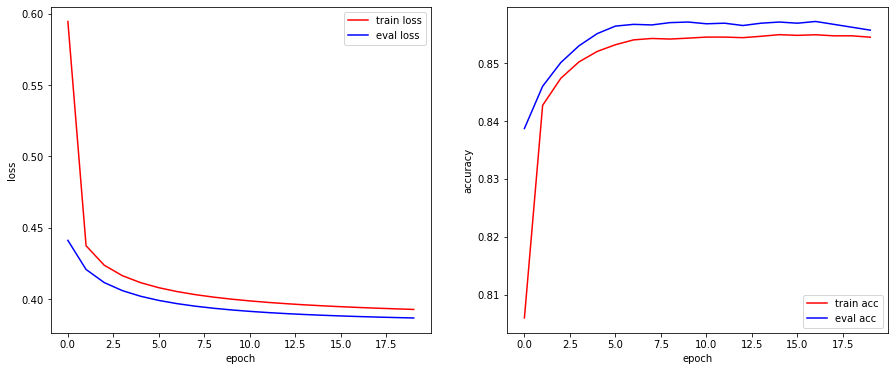

In [139]:
# TODO calculate the test loss and accuracy
mean_test_losses = []
mean_test_accs = []

for epoch in range(epochs):
    # training
    mean_test_loss_per_epoch = 0
    mean_test_acc_per_epoch = 0
    for i in range(test_data_size // batch_size):
        x, y = get_next_batch(i, batch_size, X_test, y_test)
        y_hat = do_network_inference(x, W, b)
        test_loss = get_loss(y_hat, y)
        test_accuracy = get_accuracy(y_hat, y)
        mean_test_loss_per_epoch += test_loss
        mean_test_acc_per_epoch += test_accuracy
    mean_test_loss_per_epoch = mean_test_loss_per_epoch / ((test_data_size // batch_size))
    mean_test_acc_per_epoch = mean_test_acc_per_epoch / ((test_data_size // batch_size))
    mean_test_losses.append(mean_test_loss_per_epoch)
    mean_test_accs.append(mean_test_acc_per_epoch)

final_mean_test_loss = np.sum(mean_test_losses)/epochs
final_mean_test_acc  = np.sum(mean_test_accs)/epochs
    
print("final test loss: {0:f} \t final test acc: {1:f}".format(final_mean_test_loss, final_mean_test_acc))

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
ax1 = axs[0]
ax2 = axs[1]

ax1.plot(range(epochs), mean_train_losses, "r", label="train loss")
ax1.plot(range(epochs), mean_eval_losses, "b", label="eval loss")
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax1.legend()

ax2.plot(range(epochs), mean_train_accs, "r", label="train acc")
ax2.plot(range(epochs), mean_eval_accs, "b", label="eval acc")
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")
ax2.legend()
plt.show()